# Demo Exercise

This is a demo exercise where you can adjust the parameters of the reinforcement learning setup (e.g., number of arms, features, rounds, batch size, and network architecture) and observe how these changes affect the performance of different RL algorithms (DQN, policy gradient, and actor-critic).


In [1]:
import numpy as np
import pandas as pd
import torch
from plotnine import *
from demo.contextual_bandit_dgp import Complex, IHDP, Simple
from demo.reinforcement_learning.policy_gradient import PolicyGradient
from demo.reinforcement_learning.dqn import DQN
from demo.reinforcement_learning.actor_critic import ActorCritic
from demo.visualizations.comparison import performance_comparison_report, generate_comparison_plots

---
## 0. Setting your parameters

In [2]:
# Bandit / action-space configuration
n_arms = 3         # number of possible actions (arms)
n_features = 4     # dimensionality of the context/state feature vector

# Training configuration
n_rounds = 200     # total number of interaction steps (training rounds)
batch_size = 32    # mini-batch size used for each network update

# Neural network architecture (used by DQN, policy gradient, and actor-critic)
n_hidden_units = [128, 64, 32]  # sizes of hidden layers in the function-approximation networks

# Exploration parameter for ε-greedy policy (relevant when using DQN / value-based methods)
epsilon = 0.01     # probability of taking a random action (exploration rate)


---
## 1. Setting Up the Data Generating Process (DGP)

In [3]:
# Generate Data
dgp = Simple(n_arms=n_arms, n_features=n_features, shared_weight=0.3)

print(f"Number of arms: {n_arms}")
print(f"Number of features: {n_features}")


Number of arms: 3
Number of features: 4


---
## 2. Policy Gradient Method vs Random Assignment

In [4]:
# Initialize the policy gradient model
policy = PolicyGradient(n_features=n_features, n_actions=n_arms, n_hidden_units=n_hidden_units, lr=1e-2)

# Storage for results
pg_rewards = []
pg_regrets = []
random_rewards = []
random_regrets = []
pg_optimal_rates = []
random_optimal_rates = []

for round_idx in range(n_rounds):
    # Generate batch of contexts
    contexts = dgp.x(batch_size)

    # Get optimal arms and rewards for this batch
    optimal_arms = dgp.a_star(contexts)
    optimal_rewards = dgp.r_star(contexts)

    # --- Policy Gradient ---
    pg_actions, log_probs = policy.select_actions(contexts)
    pg_observed = dgp.r(pg_actions, contexts)
    policy.finish_batch(pg_observed, pg_actions, log_probs)

    pg_rewards.extend(pg_observed)
    pg_regrets.extend(optimal_rewards - pg_observed)
    pg_optimal_rates.append((pg_actions == optimal_arms).mean())

    # --- Random Assignment ---
    random_actions = np.random.randint(0, n_arms, size=batch_size)
    random_observed = dgp.r(random_actions, contexts)

    random_rewards.extend(random_observed)
    random_regrets.extend(optimal_rewards - random_observed)
    random_optimal_rates.append((random_actions == optimal_arms).mean())

# Convert to arrays
pg_rewards = np.array(pg_rewards)
pg_regrets = np.array(pg_regrets)
random_rewards = np.array(random_rewards)
random_regrets = np.array(random_regrets)
n_samples = len(pg_rewards)

print(f"Training complete: {n_rounds} rounds, {n_samples} total samples")

Training complete: 200 rounds, 6400 total samples


## 3. DQN vs Policy Gradient vs Random Assignment

In [5]:
# Define DQN
dqn = DQN(n_features=n_features, n_actions=n_arms, n_hidden_units=n_hidden_units, lr=1e-2, epsilon=epsilon)
dqn_rewards = []
dqn_regrets = []
dqn_optimal_rates = []

for round_idx in range(n_rounds):
    # Generate batch of contexts
    contexts = dgp.x(batch_size)

    # Get optimal arms and rewards for this batch
    optimal_arms = dgp.a_star(contexts)
    optimal_rewards = dgp.r_star(contexts)

    # --- DQN ---
    dqn_actions = dqn.select_actions(contexts)
    dqn_observed = dgp.r(dqn_actions, contexts)

    # Update dqn
    dqn.finish_batch(rewards=dqn_observed, actions=dqn_actions, states=contexts)

    # Record dqn results
    dqn_rewards.extend(dqn_observed)
    dqn_regrets.extend(optimal_rewards - dqn_observed)
    dqn_optimal_rates.append((dqn_actions == optimal_arms).mean())

# Convert to arrays
dqn_rewards = np.array(dqn_rewards)
dqn_regrets = np.array(dqn_regrets)

n_samples = len(dqn_rewards)
print(f"Simulation complete: {n_rounds} rounds, {n_samples} total samples")

Simulation complete: 200 rounds, 6400 total samples


# 4. Actor-Critic vs DQN vs Policy Gradient vs Random Assignment

In [6]:
actor_critic = ActorCritic(n_features=n_features, n_actions=n_arms, n_hidden_units=n_hidden_units, lr=1e-2)

# Storage for results
ac_rewards = []
ac_regrets = []
ac_optimal_rates = []

for round_idx in range(n_rounds):
    # Generate batch of contexts
    contexts = dgp.x(batch_size)

    # Get optimal arms and rewards for this batch
    optimal_arms = dgp.a_star(contexts)
    optimal_rewards = dgp.r_star(contexts)

    # --- Actor-Critic ---
    ac_actions, log_probs = actor_critic.select_actions(contexts)
    ac_observed = dgp.r(ac_actions, contexts)

    # Update actor-critic
    actor_critic.finish_batch(rewards=ac_observed, actions=ac_actions, states=contexts, log_probs=log_probs)

    # Record actor-critic results
    ac_rewards.extend(ac_observed)
    ac_regrets.extend(optimal_rewards - ac_observed)
    ac_optimal_rates.append((ac_actions == optimal_arms).mean())

# Convert to arrays
ac_rewards = np.array(ac_rewards)
ac_regrets = np.array(ac_regrets)

n_samples = len(ac_rewards)
print(f"Simulation complete: {n_rounds} rounds, {n_samples} total samples")

Simulation complete: 200 rounds, 6400 total samples


## Regret Analysis

In [7]:
# Create dictionary for generating plots
# Calculate cumulative regrets
random_cumulative_regret = np.cumsum(random_regrets)
pg_cumulative_regret = np.cumsum(pg_regrets)
dqn_cumulative_regret = np.cumsum(dqn_regrets)
ac_cumulative_regret = np.cumsum(ac_regrets)

regret_dict = {
    "Actor-Critic": ac_regrets,
    'DQN': dqn_regrets,
    'Policy Gradient': pg_regrets,
    'Random': random_regrets,
}

cumulative_regrets_dict = {
    "Actor-Critic": ac_cumulative_regret,
    'DQN': dqn_cumulative_regret,
    'Policy Gradient': pg_cumulative_regret,
    'Random': random_cumulative_regret,
}
optimal_rate_dict = {
    "Actor-Critic": ac_optimal_rates,
    'DQN': dqn_optimal_rates,
    'Policy Gradient': pg_optimal_rates,
    'Random': random_optimal_rates,
}

# Creates pg_rolling and random_rolling dataframes
window = 10
rolling_window = batch_size * window
ac_rolling = pd.Series(ac_regrets).rolling(window=rolling_window).mean().values
dqn_rolling = pd.Series(dqn_regrets).rolling(window=rolling_window).mean().values
pg_rolling = pd.Series(pg_regrets).rolling(window=rolling_window).mean().values
random_rolling = pd.Series(random_regrets).rolling(window=rolling_window).mean().values

# Create a dictionary for rolling_regret
rolling_regret_dict = {
    'Actor-Critic': ac_rolling,
    'DQN': dqn_rolling,
    'Policy Gradient': pg_rolling,
    'Random': random_rolling,
}


In [8]:
p_cumulative, p_optimal_rate, p_inst_regret, p_rolling = generate_comparison_plots(
    optimal_rate_dict=optimal_rate_dict,
    cumulative_regrets_dict=cumulative_regrets_dict,
    regrets_dict=regret_dict,
    rolling_regret_dict=rolling_regret_dict,
    methods=['Actor-Critic', 'DQN', 'Policy Gradient', 'Random'],
    n_rounds=n_rounds,
    n_samples=n_samples,
    n_arms=n_arms,
    rolling_window=rolling_window,)

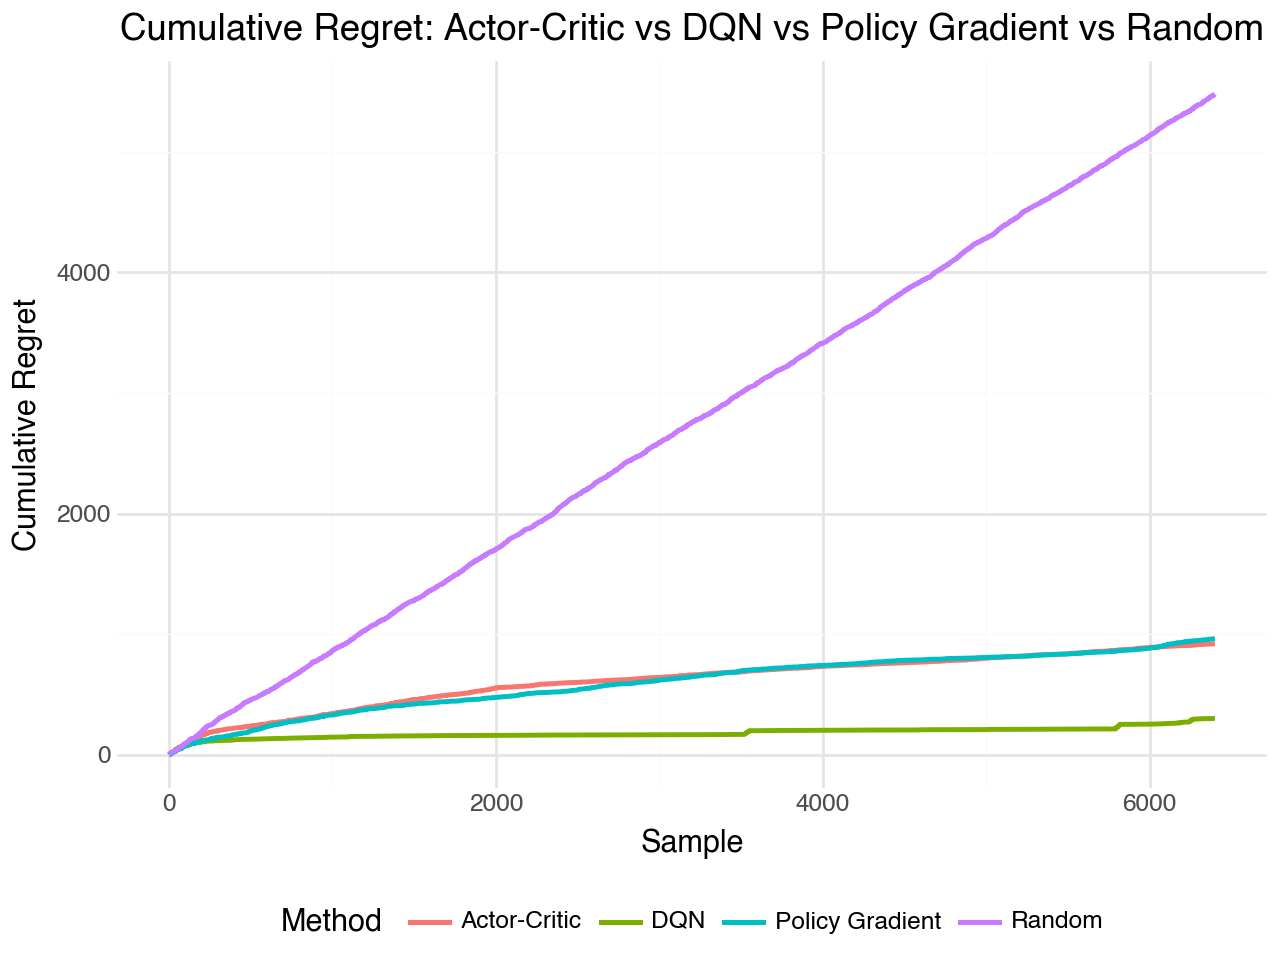

In [9]:
p_cumulative

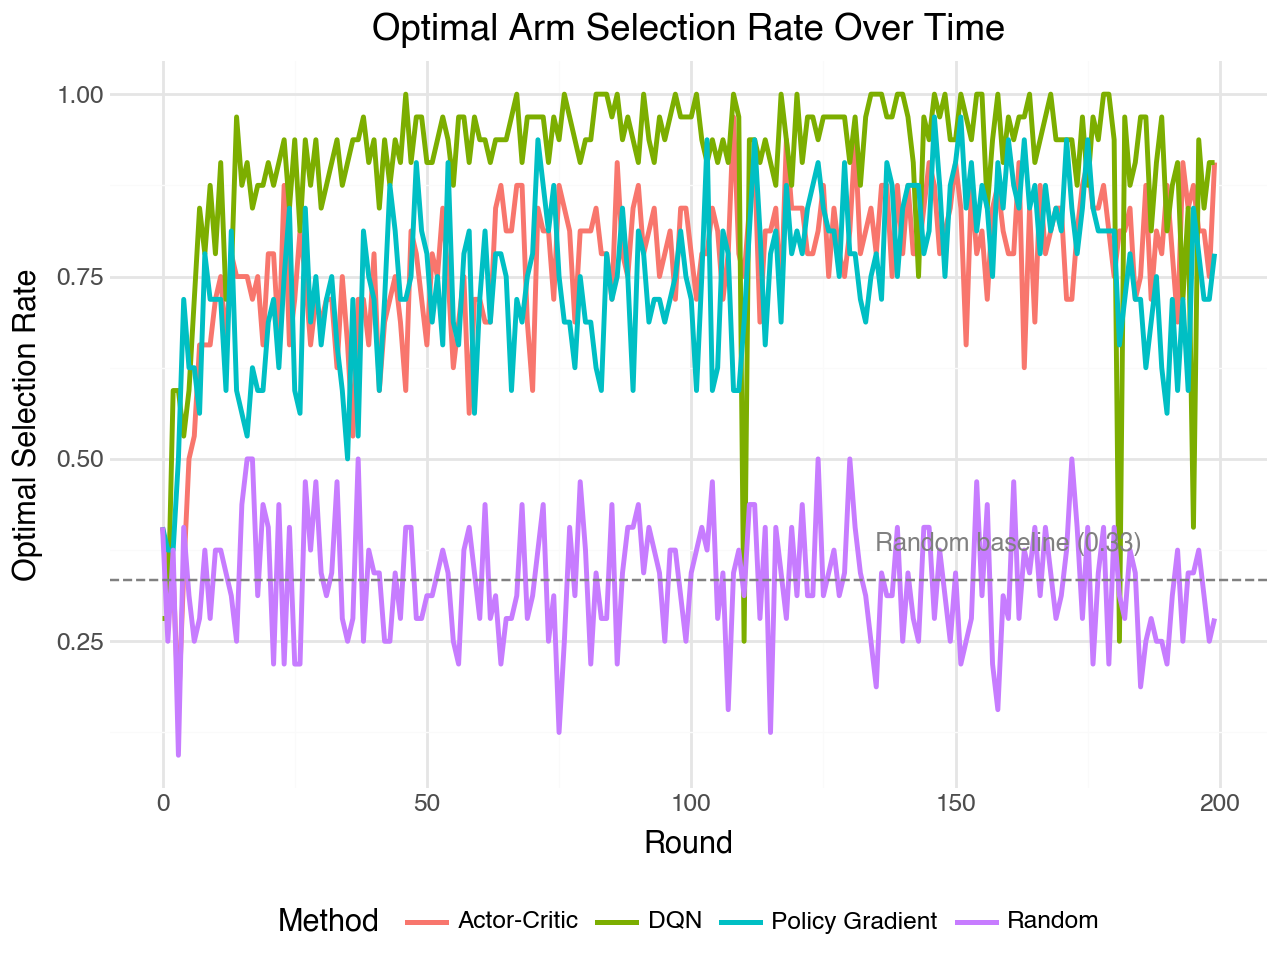

In [10]:
p_optimal_rate

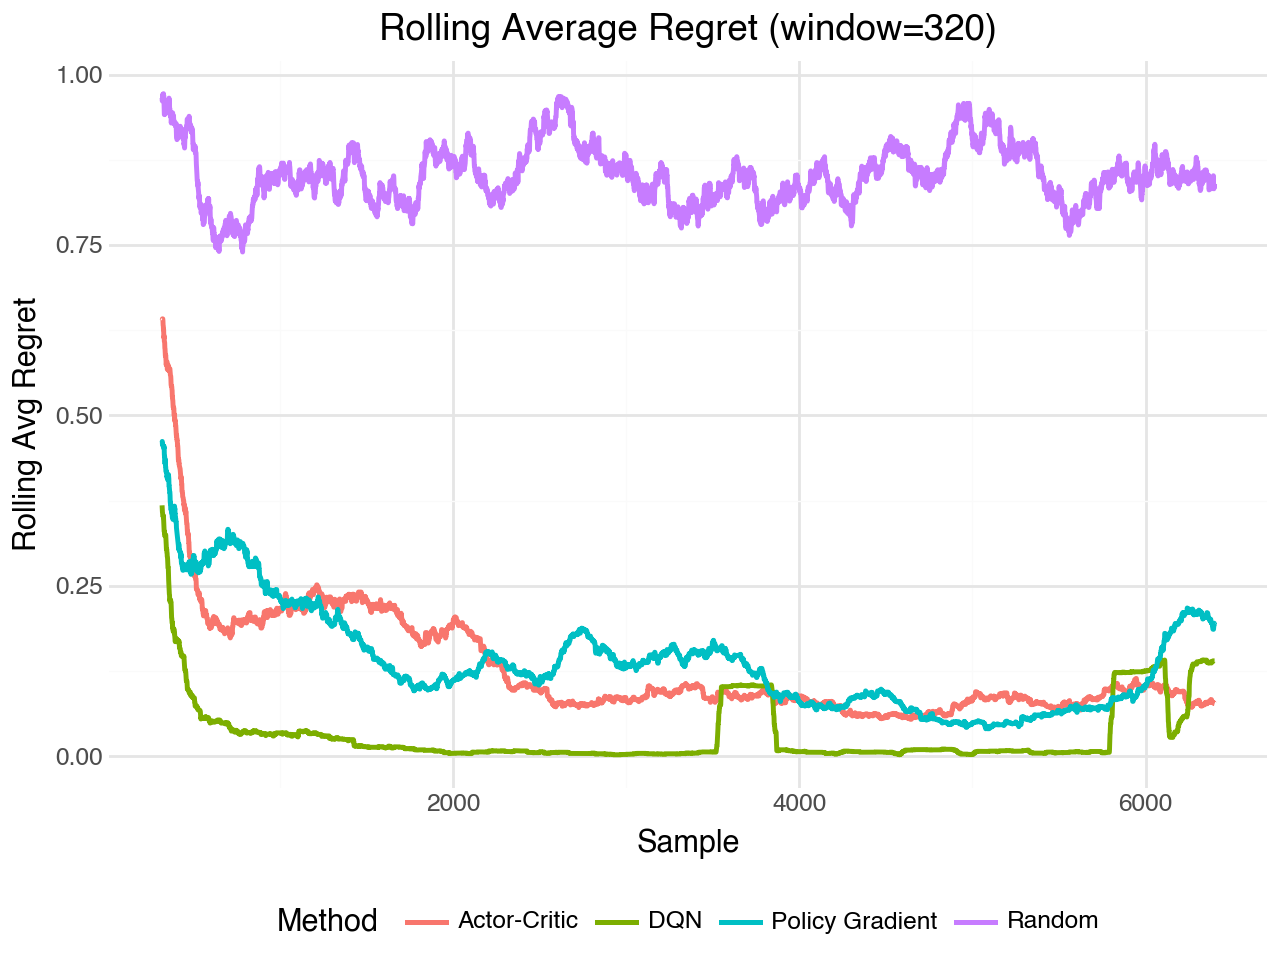

In [11]:
p_rolling

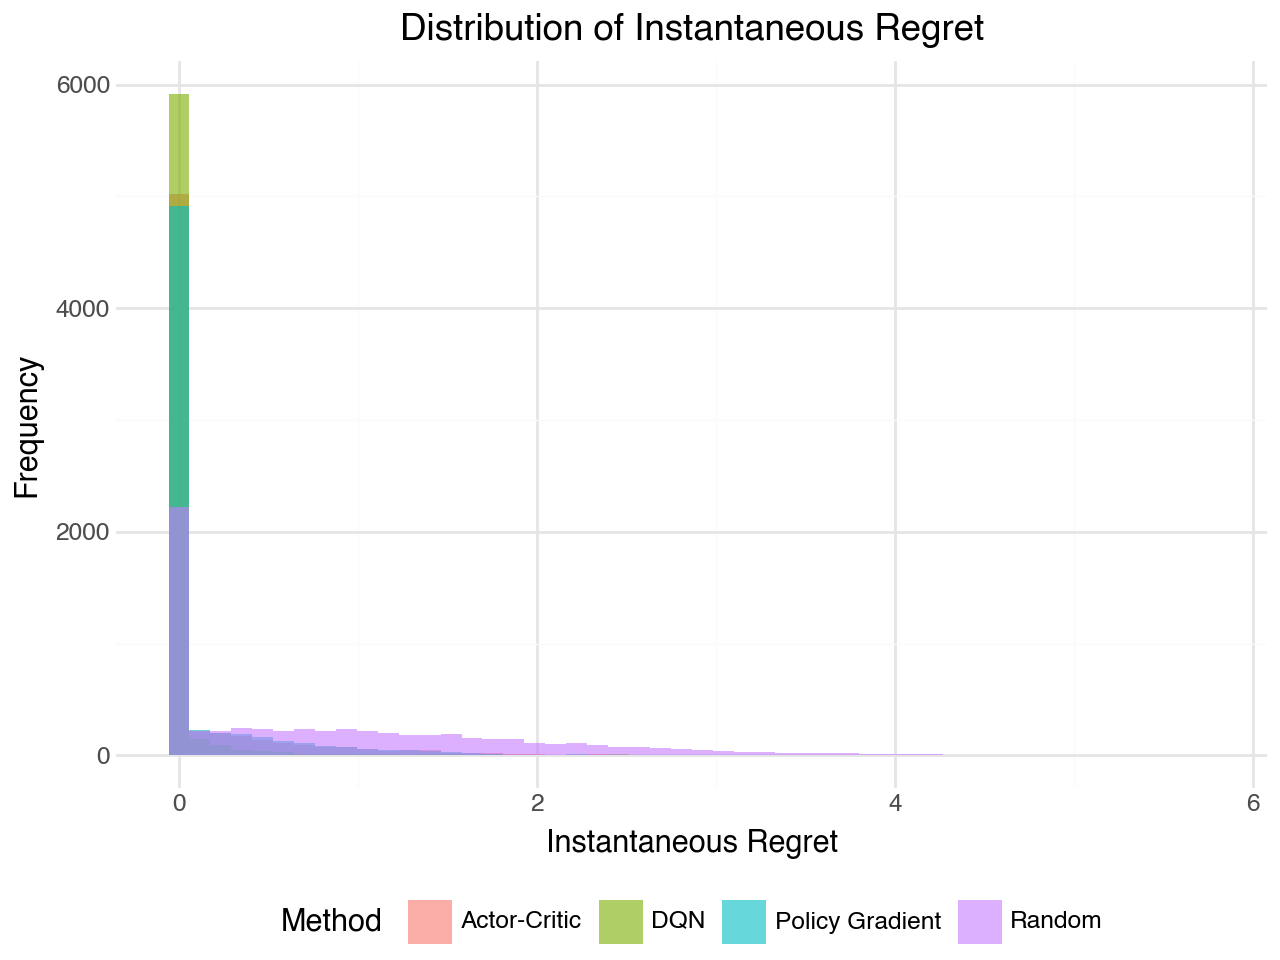

In [12]:
p_inst_regret